# **Santander Customer Transaction Prediction**

**Introduction :**

In this project we have to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

In [ ]:
# Import all required libraries 
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import lightgbm as lgb

In [ ]:
#Loading test and train datasets
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

In [ ]:
#Checking the train data
df_train.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.284,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.800,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [ ]:
df_train.shape

(200000, 202)

In [ ]:
#Checking data type
df_train.dtypes.value_counts()


float64    200
int64        1
object       1
dtype: int64

In [ ]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

**Exploratory data analysis**

In [ ]:
#Checking null values
df_train.isnull().values.any(),    df_test.isnull().values.any()

(False, False)

In [ ]:
# Checking if every row has unique id
len(df_train['ID_code'].unique())

200000

In [ ]:
#Target column
df_train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

% of 1 in train data: 10.049


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


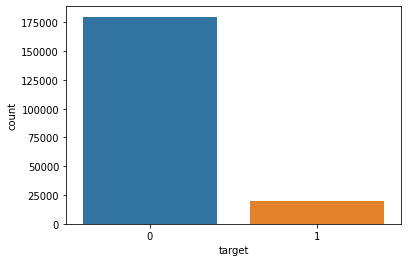

In [ ]:
sns.countplot(df_train.target)
print('% of 1 in train data:', (df_train.target.value_counts()[1]/df_train.shape[0]) * 100)

We have imbalance data

In [ ]:
#Removing the ID_code column from the train dataset

new_train=df_train.drop(['ID_code'], axis=1)
new_train.head(2)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.284,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.800,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


**SMOTE**

0    179902
1     20098
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE over-sampling:
1    179902
0    179902
Name: target, dtype: int64


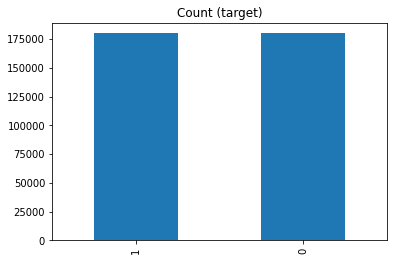

In [ ]:
# Using SMOTE for balancing the target column in train dataset

from imblearn.over_sampling import SMOTE

print(new_train.target.value_counts())

X = new_train.drop('target', axis=1)
Y = new_train['target']

sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)

df_smote_over = pd.concat([pd.DataFrame(X_res), pd.DataFrame(Y_res, columns=['target'])], axis=1)

print('SMOTE over-sampling:')
print(df_smote_over.target.value_counts())

df_smote_over.target.value_counts().plot(kind='bar', title='Count (target)');

**Outliers**

In [ ]:
#As the data is huge, we will first calculate the z-score of the training data
from scipy import stats

# Dropping ID and target columns
z_score_calc = df_train.drop(columns=['ID_code', 'target'])
# Calculating z score
z = np.abs(stats.zscore(z_score_calc))
# print(z)
threshold = 3
print(np.where(z > 4))

(array([  5223,  15110,  27150,  28440,  36684,  39763,  50289,  54707,
        66186,  78143,  92221,  94371,  96076, 101997, 103190, 119725,
       125921, 127324, 138420, 142599, 145204, 145707, 158355, 164048,
       171009, 180741, 198357]), array([ 28,  31, 167,  58, 120, 167, 149, 106,  38, 124, 105,  44, 171,
       146, 149,  38,  31,  67, 186,  67, 192,  17,  28, 106, 124, 149,
        52]))


first array shows row number

second array shows coulmn number

In [ ]:
treated_data = df_train[(z < 4).all(axis=1)]
print("before treating outliers : {}".format(df_train.shape))
print("after treating outliers : {}".format(treated_data.shape))

before treating outliers : (200000, 202)
after treating outliers : (199973, 202)


There are total 27 outliers rows that are removed



**Creating LightGBM Model**

In [ ]:
var_columns = [c for c in df_train.columns if c not in ['ID_code','target']]

X = df_train.loc[:,var_columns]
y = df_train.loc[:,'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [ ]:
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 63,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': -1
             }

In [ ]:
model_lgbm = lgb.train(parameters,
                            train_data,
                            valid_sets=valid_data,
                            num_boost_round=5000,
                            early_stopping_rounds=50)

[1]	valid_0's auc: 0.650306
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.68966
[3]	valid_0's auc: 0.705095
[4]	valid_0's auc: 0.7239
[5]	valid_0's auc: 0.727217
[6]	valid_0's auc: 0.735538
[7]	valid_0's auc: 0.741782
[8]	valid_0's auc: 0.748645
[9]	valid_0's auc: 0.759251
[10]	valid_0's auc: 0.764201
[11]	valid_0's auc: 0.768884
[12]	valid_0's auc: 0.773915
[13]	valid_0's auc: 0.775052
[14]	valid_0's auc: 0.778513
[15]	valid_0's auc: 0.781845
[16]	valid_0's auc: 0.781421
[17]	valid_0's auc: 0.78156
[18]	valid_0's auc: 0.780985
[19]	valid_0's auc: 0.780923
[20]	valid_0's auc: 0.780405
[21]	valid_0's auc: 0.782923
[22]	valid_0's auc: 0.785029
[23]	valid_0's auc: 0.78636
[24]	valid_0's auc: 0.786945
[25]	valid_0's auc: 0.78792
[26]	valid_0's auc: 0.788143
[27]	valid_0's auc: 0.789945
[28]	valid_0's auc: 0.79113
[29]	valid_0's auc: 0.79152
[30]	valid_0's auc: 0.793156
[31]	valid_0's auc: 0.79327
[32]	valid_0's auc: 0.794845
[33]	valid_0's auc: 0.795637

In [ ]:
 y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9844
AUC Valid: 0.8948


Predicting the test data

In [ ]:
df_test = pd.read_csv('test.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
X_test = df_test.loc[:,var_columns]
df_sample_submission['target'] = model_lgbm.predict(X_test)
df_sample_submission

,ID_code,target
0,test_0,0.355928
1,test_1,0.564083
2,test_2,0.537118
3,test_3,0.457021
4,test_4,0.200810
...,...,...
199995,test_199995,0.195838
199996,test_199996,0.045373
199997,test_199997,0.014733
199998,test_199998,0.318623
